<a href="https://colab.research.google.com/github/davidfague/Model_Reduction_Methods/blob/main/Extracellular_Potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stylized Single Cell and Extracellular Potential

#### Download modules from Github

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 19.5 MB/s eta 0:00:00


In [2]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/davidfague/Model_Reduction_Methods.git

Cloning into 'Model_Reduction_Methods'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 422 (delta 64), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (422/422), 2.27 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [4]:
%cd Model_Reduction_Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import recording functions
from stylized_module.recorder import Recorder

#import analysis functions
from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology,check_connectivity,generate_reduced_cell_seg_coords, create_seg_var_report

import pandas as pd

/content/Model_Reduction_Methods


In [5]:
%cd expand_example

/content/Model_Reduction_Methods/expand_example


In [6]:
# compile the mod files
!nrnivmodl mod

/content/Model_Reduction_Methods/expand_example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mod/CaDynamics_E2.mod
Translating CaDynamics_E2.mod into /content/Model_Reduction_Methods/expand_example/x86_64/CaDynamics_E2.c
 -> NMODL ../mod/Ca_HVA.mod
Thread Safe
 -> NMODL ../mod/Ca_LVAst.mod
 -> NMODL ../mod/epsp.mod
Translating Ca_HVA.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_HVA.c
Translating Ca_LVAst.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_LVAst.c
Thread Safe
Thread Safe
 -> NMODL ../mod/Ih.mod
 -> NMODL ../mod/Im.mod
Translating epsp.mod into /content/Model_Reduction_Methods/expand_example/x86_64/epsp.c
Translating Ih

## Setup smiulation parameters

In [7]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from neuron import h
from scipy import signal
from IPython.display import display, clear_output
from ipywidgets import interactive_output, HBox, VBox, Label, Layout

from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline


h.load_file('stdrun.hoc')
# h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')


1.0

### Create a cell with reduced morphology

In [8]:
%ls

cell1.asc  example_expand.py  L5PCtemplate.hoc  x86_64/
Cell.hoc   L5PCbiophys3.hoc   mod/


In [9]:
from abc import ABC, abstractmethod
class PointCurrent(ABC):
    """A module for current point process"""

    def __init__(self, cell, sec_index, loc=0.5):
        """
        cell: target cell object
        sec_index: index of the target section in the section list
        loc: location on a section, between [0,1]
        """
        self.cell = cell
        self.sec_index = sec_index
        self.loc = loc
        self.pp_obj = None  # point process object
        self.rec_vec = None  # vector for recording

    @abstractmethod
    def setup(self, record: bool = None) -> None:
        pass

    def setup_recorder(self):
        size = [round(h.tstop / h.dt) + 1] if hasattr(h, 'tstop') else []
        self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_i)

    def get_section(self) -> h.Section:
        return self.cell.all[self.sec_index]

    def get_segment(self):
        return self.pp_obj.get_segment()

    def get_segment_id(self) -> int:
        """Get the index of the injection target segment in the segment list"""
        iseg = int(self.get_segment().x * self.get_section().nseg)
        return self.cell.sec_id_in_seg[self.sec_index] + iseg


In [10]:
class Synapse(PointCurrent):
    def __init__(self, cell, stim: h.NetStim, sec_index: int,
                  syn_type: str = 'Exp2Syn', gmax: float = 0.01, loc: float = 0.5,
                  record: bool = False):
        super().__init__(cell, sec_index, loc)
        self.stim = stim
        self.gmax = gmax
        self.__synapse_type(syn_type)
        self.setup(record)

    # PRIVATE METHODS
    def __synapse_type(self, syn_type):
        if syn_type == 'AlphaSynapse1':
            # Reversal potential (mV); Synapse time constant (ms)
            self.syn_params = {'e': 0., 'tau': 2.0}
            # Variable name of maximum conductance (uS)
            self.gmax_var = 'gmax'
        elif syn_type == 'Exp2Syn':
            self.syn_params = {'e': 0., 'tau1': 1.0, 'tau2': 3.0}
            self.gmax_var = '_nc_weight'
        else:
            raise ValueError("Synpase type not defined.")
        self.syn_type = syn_type
        self.pp_obj = getattr(h, syn_type)(self.get_section()(self.loc))

    def __setup_synapse(self):
        self.syn = self.pp_obj
        self.nc = h.NetCon(self.stim, self.syn, 1, 0, 1)
        for key, value in self.syn_params.items():
            setattr(self.syn, key, value)
        self.set_gmax()

    # PUBLIC METHODS
    def setup(self, record: bool = False):
        self.__setup_synapse()
        if record:
            self.setup_recorder()
    
    def set_gmax(self, gmax: float = None):
        if gmax is not None:
            self.gmax = gmax
        if self.gmax_var == '_nc_weight':
            self.nc.weight[0] = self.gmax
        else:
            setattr(self.syn, self.gmax_var, self.gmax)

In [11]:
from typing import Optional, Union, List
import math
class cell_model():
  '''expanded cell model class for ECP calculation
  takes cell model and does bookkeeping for analysis functions
  '''
  def __init__(self,model,spike_threshold: Optional[float] = None):
    self.all=model.all
    self.soma=model.soma
    self.apic=model.apic
    self.dend=model.dend
    self.axon=model.axon
    self.spike_threshold = spike_threshold
    self.segments=[]
    self.injection=[]
    self.synapse = []  # synapse objects
    self.sec_id_lookup = {}  # dictionary from section type id to section index
    self.sec_id_in_seg = []  # index of the first segment of each section in the segment list
    self.sec_angs = [] # list of angles that were used to branch the cell
    self.generate_sec_coords()
    self.__store_segments()
    self.__set_spike_recorder()
    self.__calc_seg_coords()
    self.grp_ids = []
    #self.generate_geometry_file()

  def __calc_seg_coords(self):
    """Calculate segment coordinates for ECP calculation"""
    p0 = np.empty((self._nseg, 3))
    p1 = np.empty((self._nseg, 3))
    p05 = np.empty((self._nseg, 3))
    r = np.empty(self._nseg)
    for isec, sec in enumerate(self.all):
        iseg = self.sec_id_in_seg[isec]
        nseg = sec.nseg
        pt0 = np.array([sec.x3d(0), sec.y3d(0), sec.z3d(0)])
        pt1 = np.array([sec.x3d(1), sec.y3d(1), sec.z3d(1)])
        pts = np.linspace(pt0, pt1, 2 * nseg + 1)
        p0[iseg:iseg + nseg, :] = pts[:-2:2, :]
        p1[iseg:iseg + nseg, :] = pts[2::2, :]
        p05[iseg:iseg + nseg, :] = pts[1:-1:2, :]
        r[iseg:iseg + nseg] = sec.diam / 2
    self.seg_coords = {'dl': p1 - p0, 'pc': p05, 'r': r}

  def __store_segments(self):
    self.segments = []
    self.sec_id_in_seg = []
    nseg = 0
    for sec in self.all:
        self.sec_id_in_seg.append(nseg)
        nseg += sec.nseg
        for seg in sec:
            self.segments.append(seg)
            self.__store_point_processes(seg)
    self._nseg = nseg

  def __store_point_processes(self,seg):
    for pp in seg.point_processes():
        self.injection.append(pp)

  def __set_spike_recorder(self, threshold: Optional = None):
      if threshold is not None:
          self.spike_threshold = threshold
      if self.spike_threshold is None:
          self.spikes = None
      else:
          vec = h.Vector()
          nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
          nc.threshold = self.spike_threshold
          nc.record(vec)
          self.spikes = vec

  def add_synapse(self, stim: h.NetStim, sec_index: int, **kwargs):
        """Add synapse to a section by its index"""
        self.synapse.append(Synapse(self, stim, sec_index, **kwargs))

  def generate_sec_coords(self):
      '''
      Note: need to improve branching so that it is random direction in a quadrant of a sphere rather than x-y plane
      takes a cell that has no n3d() coordinates and gives new coordinates
      by choosing an arbitrary direction for the subtree to move
      '''
      parent_sections=[] #list for already seen parent_sections
      section_obj_list= self.all
      # print(section_obj_list)
      axial=False
      for sec in section_obj_list:
        if sec is self.soma:
          self.sec_angs.append(0)
          pt0 = [0., -1 * sec.diam, 0.]
          pt1 = [0., 0., 0.]
          sec.pt3dclear()
          sec.pt3dadd(*pt0, sec.diam)
          sec.pt3dadd(*pt1, sec.diam)
          print('Changing soma nseg from',sec.nseg,'to 1')
          sec.nseg = 1
        else:
          if sec.parentseg() is not None:
            psec=sec.parentseg().sec
            if psec==self.soma:
              nbranch=1
            else:
              nbranch = len(psec.children())
          else:
            psec=None # may need to provide more implementation in the case of no 3d coords and no parent section.
            nbranch=1
          rot = 2 * math.pi/nbranch
          i=parent_sections.count(psec)
          parent_sections.append(psec)
          length=sec.L
          diameter=sec.diam
          fullsecname = sec.name()
          # print(fullsecname)
          sec_type = fullsecname.split(".")[1][:4]
          # print(sec_type)
          if sec_type == "apic":
            ang=np.random.normal(scale=0.1,loc=1.570796327) # somewhat arbitrary angle in the Q1/Q2 of xy-plane # may adjust as needed
          elif sec_type=="dend":
            ang=-np.random.uniform(low=0,high=np.pi) # arbitrary angle in the Q3/Q4 of xy=plane # may adjust as needed 
          else:
            print(sec,sec_type,' is not apic or dend')
            ang=0
          if axial == True:
            x = 0
            y = length*((ang>=0)*2-1)
          else:
            x = length * math.cos(ang)
            y = length * math.sin(ang)
          self.sec_angs.append(ang)
          #find starting position
          pt0 = [psec.x3d(1), psec.y3d(1), psec.z3d(1)]
          pt1 = [0., 0., 0.]
          pt1[1] = pt0[1] + y
          pt1[0] = pt0[0] + x * math.cos(i * rot)
          pt1[2] = pt0[2] + x * math.sin(i * rot)
          sec.pt3dclear()
          sec.pt3dadd(*pt0, sec.diam)
          sec.pt3dadd(*pt1, sec.diam)

  def generate_geometry_file(self):
    '''
    generates geometry file specifying name, pid, ang, radius, length, type
    work in progress
    '''
    df = pd.DataFrame()
    ids=[]
    names=[]
    types=[]
    pids=[]
    axials=[]
    nbranchs=[]
    Ls=[]
    Rs=[]
    angs=self.angs
    for sec in self.all:
      # print(dir(sec))
      name=sec.name()
      # print(name)
      names.append(name)
      ids.append(names.index(name))
      _,sec_type_withinteger=name.split('.')
      sec_type,_=sec_type_withinteger.split('[')
      types.append(sec_type)
      pseg = sec.parentseg()
      if pseg == None:
        pids.append(None)
      else:
        psec=pseg.sec
        px3d=psec.x3d
        pids.append(names.index(psec.name()))
      axials.append('TRUE')
      nbranchs.append(1)
      Ls.append(sec.L)
      # print(dir(sec))
      Rs.append(sec.diam/2)
      self.geometry=df

In [12]:

# # Load biophysical parameters from a json file
# filepath = os.path.join(paths.RESOURCES_ROOT, 'biophys_parameters/ReducedOrderL5_passive.json')
# with open(filepath) as f:
#     biophys_param = json.load(f)
# for genome in biophys_param['genome']:
#     if genome['value'] != "": genome['value'] = float(genome['value'])

h.load_file('L5PCbiophys3.hoc')

# # Load morphology parameters from a csv file
# geometry = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.load_file("import3d.hoc")


# Create a cell object
# cell = ReducedOrderL5CellPassiveDendrite(geometry=geometry, full_biophys=biophys_param)
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

synapses_list=[]
netcons_list=[]

#reduce dendritic trees to cables
reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

# print('reduced cell n3d')
# for sec in reduced_cell.dend:
#   print(sec,sec.n3d())

#expand cables to idealized dendritic trees
sections_to_expand = [reduced_cell.hoc_model.apic[0]]
furcations_x=[0.289004]
nbranches=[4]
reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                          synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
# print('dendritic cell n3d')
# for sec in reduced_dendritic_cell.all:
#   print(sec, sec.n3d())

#use defined cell_model class for generating 3d coordinates, recording ECP, 'book-keeping' etc...
cell=cell_model(reduced_dendritic_cell)
cell._nbranch=4

# Create synaptic input
stim = h.NetStim()
stim.number = 1  # only one event
stim.start = 2.0  # delay (ms)
gmax = 0.02  # default synapse maximum conductance (uS)
# Add synapse to soma
cell.add_synapse(stim, sec_index=0, gmax=gmax)
# Add synapse to apical tufts
for i,sec in enumerate(cell.apic):
    cell.add_synapse(stim, sec_index=cell.all.index(sec), gmax=gmax / cell._nbranch) # need to adjust to only tufts


trunk_diam: 3.7176523208618155 |trunk_length: 698.0975964944687 |branch_diam: 1.475351301247016 |branch_length: 1081.9141048660235
Changing soma nseg from 1 to 1
L5PCtemplate[0].axon[0] axon  is not apic or dend
L5PCtemplate[0].axon[1] axon  is not apic or dend


In [13]:
# # compare 
# for sec in cell.all:
#   for i in range(sec.n3d()):
#     print(sec.x3d(i))

In [14]:
# print(cell.seg_coords['pc'][0])

In [15]:
# dir(cell)

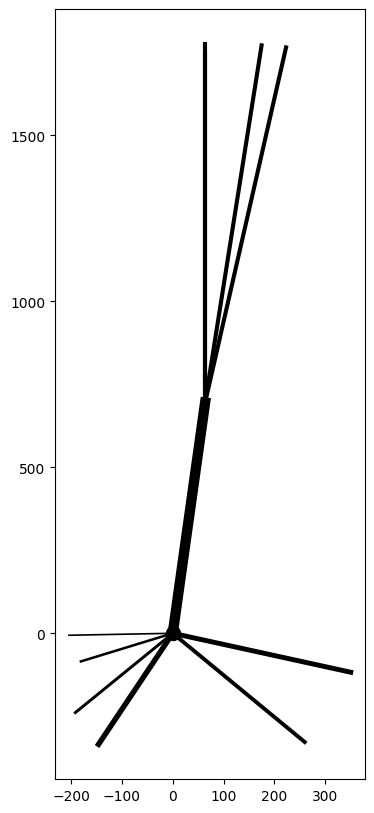

In [16]:
make_reduced_seg_df(cell,"segments_expanded.csv") #need to improve make_reduced_seg_df
expanded_segments_df=pd.read_csv("segments_expanded.csv")
plot_morphology(expanded_segments_df,"expanded_morphology.svg")

In [17]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null 
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


In [18]:
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell, ReducedOrderL5CellPassiveDendrite
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

In [19]:
h.dt = params.DT  # time step
h.steps_per_ms = 1/h.dt
h.tstop = params.TSTOP  # simulation stop time

# Record time points
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)

# Record membrane voltage of all segments
V_rec = Recorder(cell.segments)

### Add electrodes (Neuropixel)
A probe with 384 electrodes [https://www.neuropixels.org/probe](https://www.neuropixels.org/probe). The coordinates of each electrode is a row in the array printed below.

In [20]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# coordinates (x, y, z) of electrodes
print(params.ELECTRODE_POSITION.shape)
print(params.ELECTRODE_POSITION)

(384, 3)
[[   -8. -1910.     0.]
 [   24. -1910.     0.]
 [  -24. -1890.     0.]
 ...
 [   24.  1890.     0.]
 [  -24.  1910.     0.]
 [    8.  1910.     0.]]


## Custom settings

Using the interactive tools below, you can change the position of the cell, and change the synapse strength and location on the cell.

#### Cell position parameters (x, y, z, alpha, h, phi)
Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate beta=arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

Use the sliders to change the 6 position parameters. Use the sliders 'elev' and 'azim' to change view of the 3D plot.

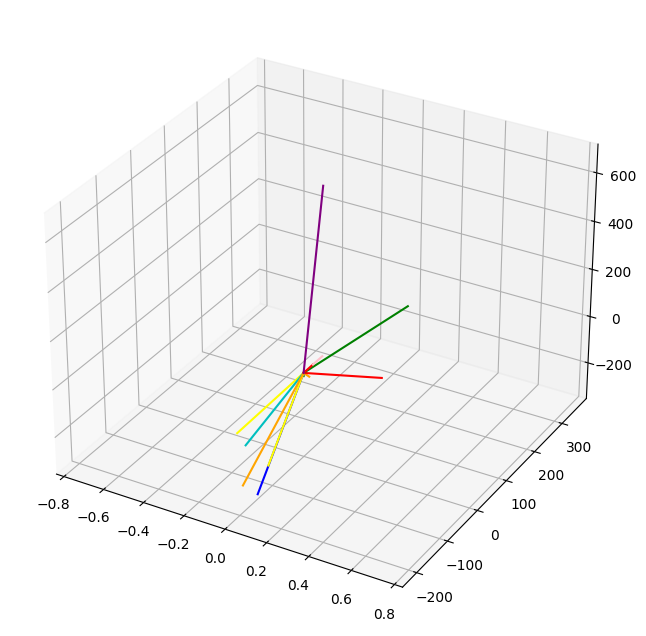

In [21]:
loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, -70  # Default view
clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color

def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

#### Set synaptic input

Use the toggle button to switch synapse location between the soma and the proximal apical tuft dendrite. Use the slider 'Synapse maximal conductance' to change synapse strength.

In [22]:
w_syn_site = widgets.ToggleButtons(options=['Soma', 'Apical tuft (proximal)'])
w_gmax = widgets.FloatSlider(value=gmax, min=0, max=0.1, step=0.0002, readout_format='.4f')
display(VBox([w_syn_site, HBox([Label('Synapse maximal conductance (uS)'), w_gmax])]))

def set_synapse():
    soma_syn = w_syn_site.value == 'Soma'
    gmax_soma = w_gmax.value if soma_syn else 0
    gmax_tuft = 0 if soma_syn else w_gmax.value / cell._nbranch
    cell.synapse[0].set_gmax(gmax_soma)
    for syn in cell.synapse[1:]:
        syn.set_gmax(gmax_tuft)

## Run simulation and plot results

Run the codes below to simulate and display results everytime after you change the parameters above.

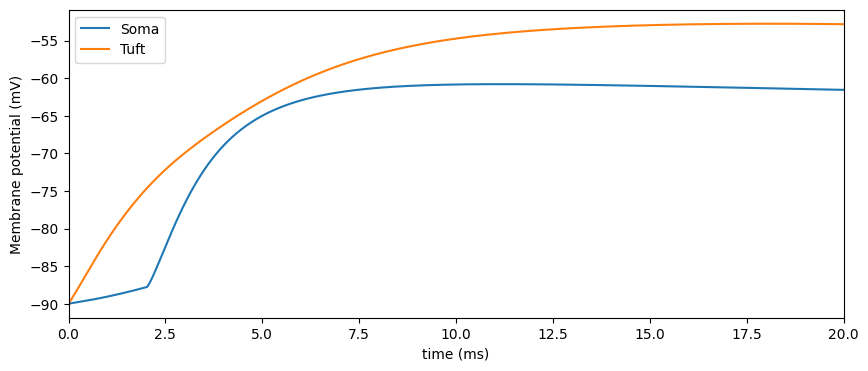

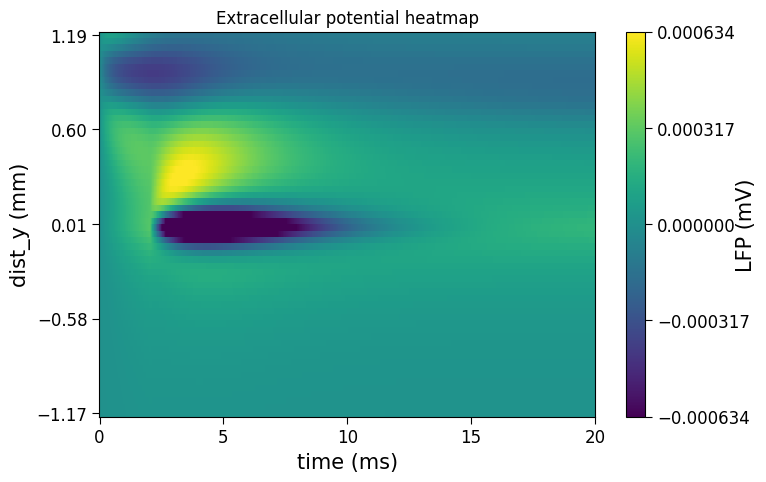

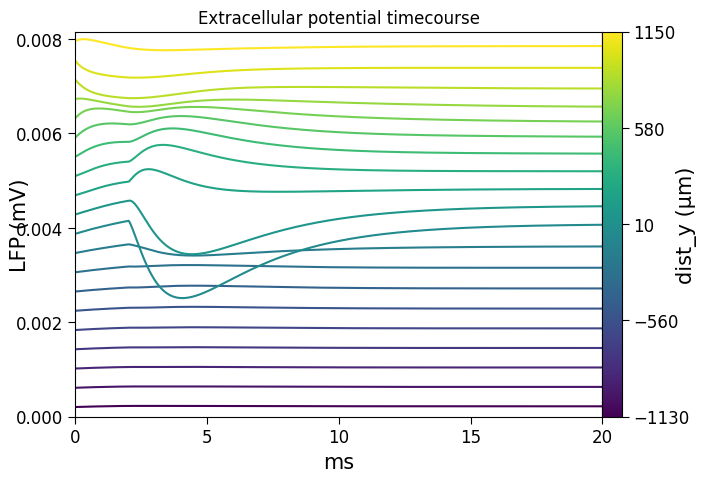

In [23]:
# Run simulation
set_synapse()
h.run()
# Get results
t = t_vec.as_numpy().copy()  # time array (ms)
# soma membrane potential
Vm = V_rec.as_numpy()
v_soma = Vm[cell.sec_id_in_seg[cell.all.index(cell.soma)]]
v_tfut = Vm[cell.sec_id_in_seg[cell.all.index(cell.apic[1])]]
# lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV

# Soma membrane potential
plt.figure(figsize=(10, 4))
plt.plot(t, v_soma, label='Soma')
plt.plot(t, v_tfut, label='Tuft')
plt.ylabel('Membrane potential (mV)')
plt.xlabel('time (ms)')
plt.xlim(t[[0, -1]])
plt.legend()

# Extracellular potential along y-axis
y_window = [-1200, 1200]  # select range of y coordinate for plotting
ylim = loc_param[1] + np.array(y_window)  # set range of y coordinate
max_idx = np.argmax(np.amax(np.abs(lfp), axis=0))  # find the electrode that records maximum magnitude
x_dist = elec_pos[max_idx, 0]  # x coordinate of the maximum magnitude electrode
e_idx = (elec_pos[:, 0]==x_dist) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # selected electrode indices

fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.title('Extracellular potential heatmap')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp[:, e_idx][:,1::3], electrodes=elec_pos[e_idx][1::3],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Extracellular potential timecourse')

plt.show()

## Electrotonic distance

Neuron has a tool for electrotonic analysis [https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html](https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html). It computes the electrotonic distance defined by attenuation, but the classical definition is [anatomical distance/length constant](https://www.neuron.yale.edu/neuron/static/docs/zclass/NIPS94/nipsfin.html).

The plot below shows the membrane potential timecourse at several locations on the cell. The electrotonic distance computed by Neuron of each location is also shown with both number and color. The distance should always be a positive value, but it is labeled negative for the basal dendrites and the axon intentionally so that it can be easily distinguished from the apical dendrites.

In [24]:
for syn in cell.synapse:
    syn.set_gmax(0)
h.run()

sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
freq = 0 # Hz
seg_prop, _, _ = measure_segment_distance(cell.soma , cell.all, sec_type, freq)

select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
select_seg = np.sum(np.array(select_seg), axis=1)
# select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
_ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
                                  distance_type='elec_dist', n_dist=300,
                                  select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
                                  space=2., normalized_space=True, sort_by_dist=True,
                                  figsize=(10, 10), fontsize=15, scalebar_size=50)

NameError: ignored

##Transfer Impedance



In [ ]:
import numpy as np
from neuron import h
import cmath

def measure_segment_transfer_impedance(soma, section_list, sec_type, freq=0, extracellular_mechanism=True):
    """
    soma: soma section object
    section_list: list of sections
    sec_type: list of swc type id of sections
    freq: frequency (Hz) at which electrotonic distance is evaluated
    extracellular_mechanism: whether extracellular mechanism is used
    """
    seg_prop = {}
    swc_type = []
    seg_area = []
    seg_dist = []
    seg_length = []
    elec_dist = [] #modulus part of polar form #should change names
    elec_dist0 = [] #modulus of polar form #should change names
    transfer_imps = [] #real part of rectangular form
    transfer_imps0 = [] # real part of rectangular form

    # set up distance origin
    h.distance(0, soma(.5))
    # set up electrotonic origin
    zz = h.Impedance()
    zz.loc(soma(.5))
    if extracellular_mechanism:
        zz.compute(freq + 1 / 9e9, 0) #*
    else:
        zz.compute(freq, 1)
    # measure distance
    for i, sec in enumerate(section_list):
        if sec_type[i]==1:
            transfer_imp=zz.transfer(sec(0.5/sec.nseg)) #*
            transfer_phase=zz.transfer_phase(sec(0.5/sec.nseg)) #*
            elec_dist0.append(transfer_imp) #*
            rect_complex=cmath.rect(transfer_imp,transfer_phase)
            transfer_imps.append(rect_complex.real) #*
        else:
            transfer_imp=zz.transfer(sec.parentseg()) #*
            transfer_phase=zz.transfer_phase(sec.parentseg()) #*
            elec_dist0.append(transfer_imp) #*
            rect_complex=cmath.rect(transfer_imp, transfer_phase) #*
            transfer_imps.append(rect_complex.real) #*
        for j, seg in enumerate(sec):
            swc_type.append(sec_type[i])
            seg_area.append(seg.area())
            seg_dist.append(h.distance(seg))
            seg_length.append(sec.L/sec.nseg)
            if j!=0:
                elec_dist0.append(elec_dist[-1])
                transfer_imps.append(transfer_imps0[-1])
            elec_dist.append(zz.transfer(seg)) #*
            transfer_imp=zz.transfer(seg) #*
            transfer_phase=zz.transfer_phase(seg) #*
            rect_complex=cmath.rect(transfer_imp,transfer_phase) #*
            transfer_imps0.append(rect_complex.real) #*

    seg_prop['swc_type'] = np.array(swc_type)
    seg_prop['seg_area'] = np.array(seg_area)

    # distance at endpoints of each segment
    seg_prop['distance'] = np.expand_dims(seg_dist, 1) + np.expand_dims(seg_length, 1) / 2 * np.array([[-1, 1]])
    # seg_prop['transfer_imp'] = np.sort(np.log(elec_dist0[0]) - np.log(np.column_stack([elec_dist0, elec_dist])), axis=1) #*
    seg_prop['transfer_imp_mod'] = np.sort(elec_dist0[0] - np.column_stack([elec_dist0, elec_dist]), axis=1) #*
    seg_prop['transfer_imp_real'] = np.sort(transfer_imps[0] - np.column_stack([transfer_imps, transfer_imps0]), axis=1) #*


    # change sign of basal and axon types
    idx = np.nonzero((seg_prop['swc_type']==2) | (seg_prop['swc_type']==3))[0]
    seg_prop['distance'][idx] = -seg_prop['distance'][idx,::-1]
    seg_prop['transfer_imp_mod'][idx] = -seg_prop['transfer_imp_mod'][idx,::-1] #*
    seg_prop['transfer_imp_real'][idx] = -seg_prop['transfer_imp_real'][idx,::-1] #*
    return seg_prop, zz.transfer(soma(.5)), zz.transfer_phase(soma(.5))


In [ ]:
#using modulus of polar form

for syn in cell.synapse:
    syn.set_gmax(0)
h.run()

sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
freq = 0 # Hz
seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
select_seg = np.sum(np.array(select_seg), axis=1)
# select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
_ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
                                  distance_type='transfer_imp_mod', n_dist=300,
                                  select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
                                  space=2., normalized_space=True, sort_by_dist=True,
                                  figsize=(10, 10), fontsize=15, scalebar_size=50)

In [ ]:
#using real part of rectangular complex form

for syn in cell.synapse:
    syn.set_gmax(0)
h.run()

sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
freq = 0 # Hz
seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
select_seg = np.sum(np.array(select_seg), axis=1)
# select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
_ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
                                  distance_type='transfer_imp_real', n_dist=300,
                                  select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
                                  space=2., normalized_space=True, sort_by_dist=True,
                                  figsize=(10, 10), fontsize=15, scalebar_size=50)

Transfer Impedance is a complex number

In [ ]:
polar_modulus=1
polar_phase=3

complex_rectangular_form=cmath.rect(polar_modulus, polar_phase)
print(complex_rectangular_form)

In [ ]:
complex_rectangular_form.real